# Data Processing

In [2]:
import pandas as pd

df = pd.read_csv("FPA-FOD_reduced.csv", low_memory = False)

In [4]:
df = df.drop('Unnamed: 0', axis = 'columns')

unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

X = X.fillna(X.median(numeric_only=True)) #replace NANs

for col in X.columns: #convert numeric values to floats, if possible
    if X[col].dtype == 'object':
        # try converting to float — if it works, keep it numeric
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass

# K-Means Clustering

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_features = ['pr', 'tmmn', 'tmmx', 'rmin', 'rmax', 'sph', 'srad', 'etr', 'vpd',
                    'bi', 'erc', 'fm100', 'fm1000', 'EVC', 'EVT', 'EVH',
                    'Elevation', 'Slope', 'Aspect', 'TRI', 'TPI', 'Aridity_index',
                    'Population', 'GDP', 'LATITUDE', 'LONGITUDE', 'FIRE_YEAR','DISCOVERY_DOY', 'DISCOVERY_TIME']

categorical_features = ['STATE', 'COUNTY']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [27]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

kmeans = KMeans(n_clusters=12, init='k-means++', n_init=20, max_iter=300, random_state=42)
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('kmeans', kmeans)])

In [61]:
from sklearn.model_selection import train_test_split

# Combine X and y into one DataFrame temporarily
df2 = X.copy()
df2['cause'] = y_encoded

X = df2.drop(columns=['cause'])
y = df2['cause']

# Now do your train-test split as usual, making sure there is even representation of causes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts())

(1363952, 32) (340988, 32)
cause
1     428570
6     261719
0     256885
2     151984
10     79500
5      52760
11     50937
9      29934
8      26097
4      14898
7       8474
3       2194
Name: count, dtype: int64


In [62]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train.value_counts().reset_index()
counts.columns = ['cause_id', 'count']

# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])

print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
        1                  Misuse of fire by a minor 428570
        6        Railroad operations and maintenance 261719
        0                    Debris and open burning 256885
        2                  Equipment and vehicle use 151984
       10                               Other causes  79500
        5 Power generation/transmission/distribution  52760
       11                Firearms and explosives use  50937
        9                                    Smoking  29934
        8                                    Natural  26097
        4                         Arson/incendiarism  14898
        7                    Recreation and ceremony   8474
        3                                  Fireworks   2194


In [63]:
X_train

,pr,tmmn,tmmx,rmin,rmax,sph,srad,etr,vpd,bi,...,Aridity_index,Population,GDP,LATITUDE,LONGITUDE,STATE,COUNTY,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME
945911,0.0,275.500000,294.600006,20.400000,100.000000,0.00522,244.300003,6.3,0.90,56.0,...,0.33,0.0380,46203.270,40.300000,-120.538889,CA,NaN,1998,261,1455.0
814505,0.0,271.299988,293.299988,23.300001,100.000000,0.00392,149.800003,4.4,0.85,26.0,...,0.74,0.0659,43145.750,35.047083,-83.789283,NC,Clay,2010,67,1225.0
2074799,8.6,292.600006,304.000000,48.000000,100.000000,0.01446,176.300003,4.9,1.02,0.0,...,0.90,0.0380,35151.234,31.260420,-94.697910,TX,Angelina,1994,252,1455.0
421807,0.0,276.700012,291.200012,34.100002,85.400002,0.00466,230.900009,5.3,0.69,46.0,...,0.32,1.1492,48723.184,32.736173,-96.276283,TX,Kaufman,2014,78,1455.0
277337,0.7,269.700012,287.799988,34.900002,82.800003,0.00323,280.500000,4.7,0.60,0.0,...,0.31,0.0085,40647.918,45.264722,-116.351389,ID,49,2008,113,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381149,0.0,294.299988,311.700012,11.700000,52.500000,0.00806,262.700012,12.3,3.52,81.0,...,0.13,0.0380,34197.273,33.301700,-110.542300,AZ,NaN,1995,212,1945.0
1908753,0.0,294.299988,307.899994,37.200001,93.700005,0.01580,241.699997,7.4,1.49,27.0,...,0.67,0.0380,32394.828,34.775521,-88.530543,MS,Alcorn,1999,214,2330.0
193016,0.0,276.299988,295.899994,20.500000,72.200005,0.00391,283.100006,6.1,1.16,24.0,...,1.16,0.0329,45808.200,36.448850,-83.362067,TN,HANCOCK,2018,111,1500.0
931514,0.0,289.399994,301.700012,46.000000,82.700005,0.01133,309.399994,6.7,1.12,34.0,...,1.41,0.0380,41172.266,43.700100,-122.802800,OR,NaN,1998,210,1745.0


In [64]:
y_train

945911     5
814505     1
2074799    1
421807     1
277337     0
          ..
381149     0
1908753    0
193016     1
931514     6
177885     0
Name: cause, Length: 1363952, dtype: int64

In [65]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [66]:
y_pred = model.predict(X_test)

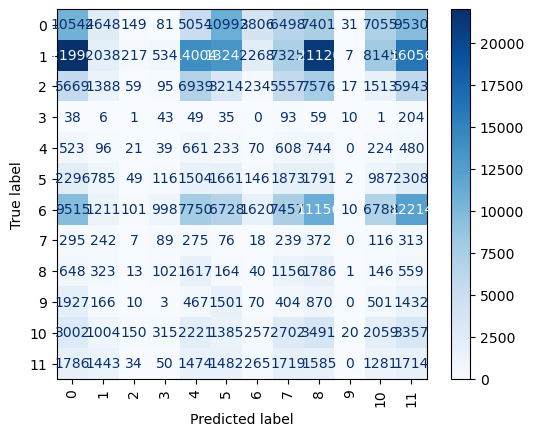

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')

plt.savefig('Kmeans_cm.png')
plt.show()

In [74]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import numpy as np

# Map each cluster label to the most frequent true label in that cluster (using training set info)
def map_clusters_to_labels(y_true, y_clusters):
    labels = np.zeros_like(y_clusters)
    for cluster in np.unique(y_clusters):
        mask = (y_clusters == cluster)
        cluster_labels = np.array(y_true)[mask] 
        m = mode(cluster_labels) #Which true class label occurs most frequently in this cluster?
        # Handle scalar or array-like output
        if hasattr(m.mode, "__iter__"):
            labels[mask] = m.mode[0]
        else:
            labels[mask] = m.mode
    return labels

# Apply mapping
y_pred_mapped = map_clusters_to_labels(y_test.values, y_pred)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred_mapped)
print(f'KMeans Clustering Accuracy: {acc:.4f}')

KMeans Clustering Accuracy: 0.3218


In [72]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# y_test: true labels; y_pred: predicted labels (can be mapped as in your earlier code)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_mapped)

# Precision, Recall, F1 (macro averages for multiclass)
precision = precision_score(y_test, y_pred_mapped, average='macro')
recall = recall_score(y_test, y_pred_mapped, average='macro')
f1 = f1_score(y_test, y_pred_mapped, average='macro')

# Cohen's Kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred_mapped)

# Matthew’s Correlation Coefficient
matthews_corr = matthews_corrcoef(y_test, y_pred_mapped)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print(f"Matthew’s Correlation Coefficient: {matthews_corr:.4f}")


Accuracy: 0.3218
Precision (macro): 0.0731
Recall (macro): 0.0931
F1 Score (macro): 0.0670
Cohen’s Kappa: 0.0413
Matthew’s Correlation Coefficient: 0.0595


/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
